In [24]:
# Essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the preprocessed data
with open('processed_data.pkl', 'rb') as f:
    data = pickle.load(f)
    
# Extract the components
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
scalers = data['scalers']

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (1320, 60, 10)
y_train shape: (1320, 1)


In [26]:
def create_improved_cnn_model(input_shape):
    """
    Create an improved CNN model with:
    1. Batch Normalization - Helps stabilize training
    2. Better regularization - Prevents overfitting
    3. Simplified architecture - Easier to understand and train
    """
    model = Sequential([
        # Input layer
        Input(shape=input_shape),
        
        # First CNN block
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        BatchNormalization(),  # Added to stabilize training
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        
        # Second CNN block
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        BatchNormalization(),  # Added to stabilize training
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        
        # Flatten layer
        Flatten(),
        
        # Dense layers with batch normalization
        Dense(50, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        # Output layer
        Dense(1)
    ])
    
    # Use a slightly lower learning rate for better stability
    optimizer = Adam(learning_rate=0.0005)
    
    model.compile(optimizer=optimizer,
                 loss='mse',
                 metrics=['mae'])
    
    return model

# Create and display model
input_shape = (X_train.shape[1], X_train.shape[2])
model = create_improved_cnn_model(input_shape)
model.summary()

print(f"\nInput shape: {input_shape}")
print(f"This means:")
print(f"- {input_shape[0]} time steps (days)")
print(f"- {input_shape[1]} features per time step")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 58, 32)         │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 58, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 29, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 29, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 27, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 27, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 13, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 13, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 832)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 50)             │        41,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,485 (193.30 KB)

 Trainable params: 49,193 (192.16 KB)

 Non-trainable params: 292 (1.14 KB)


Input shape: (60, 10)
This means:
- 60 time steps (days)
- 10 features per time step


In [27]:
# Define improved callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,  # Increased patience
    restore_best_weights=True,
    verbose=1
)

# Learning rate reduction
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce LR by 20% when plateau
    patience=5,
    min_lr=0.00001,
    verbose=1
)

# Train the model
print("Starting model training...")
print(f"Training on {len(X_train)} sequences")
print(f"Using validation split: 20%")

history = model.fit(
    X_train,
    y_train,
    epochs=50,  # Reduced epochs since we have early stopping
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Starting model training...
Training on 1320 sequences
Using validation split: 20%
Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3997 - mae: 0.9191 - val_loss: 0.3725 - val_mae: 0.6042 - learning_rate: 5.0000e-04
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8308 - mae: 0.6935 - val_loss: 0.2747 - val_mae: 0.5161 - learning_rate: 5.0000e-04
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6213 - mae: 0.5952 - val_loss: 0.2019 - val_mae: 0.4419 - learning_rate: 5.0000e-04
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4831 - mae: 0.5193 - val_loss: 0.1980 - val_mae: 0.4357 - learning_rate: 5.0000e-04
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3975 - mae: 0.4568 - val_loss: 0.2951 - val_mae: 0.5366 - learning_rate: 5.0000e-04
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3883 - mae: 0.4529 - val_loss: 0.1430 - val_mae: 0.3714 - learning_rate: 5.0000e-04
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

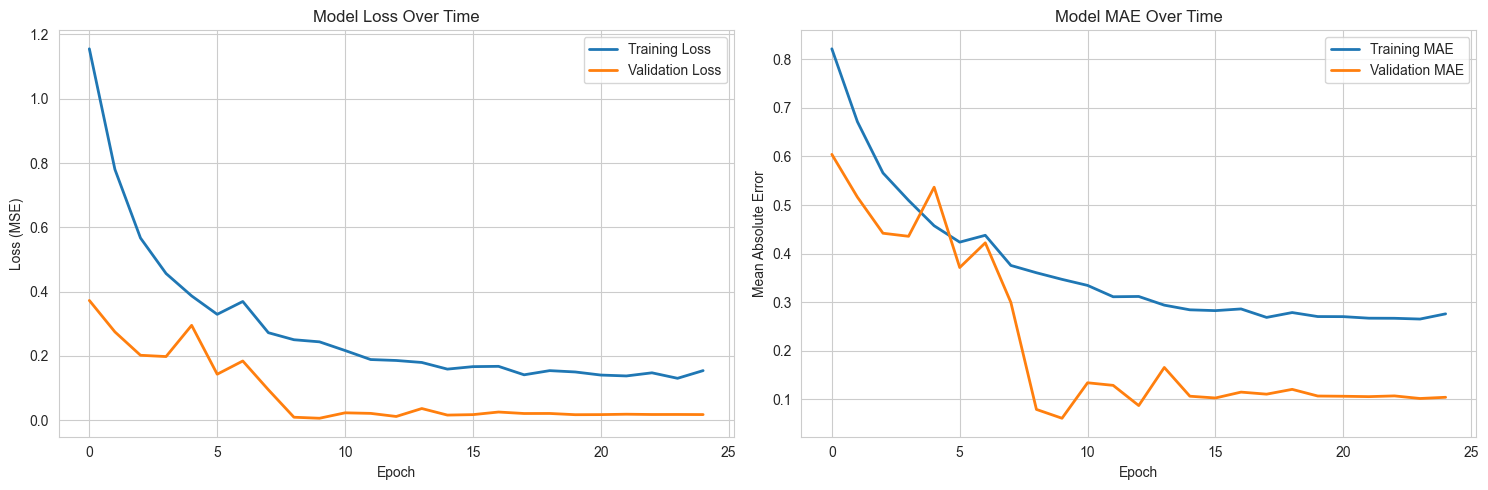


Training Summary:
Best epoch: 10
Best validation loss: 0.0060
Final training loss: 0.1542

Making predictions...
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Model Performance Metrics:
Root Mean Square Error (RMSE): $19.56
Mean Absolute Error (MAE): $15.91
R-squared Score (R²): 0.0045


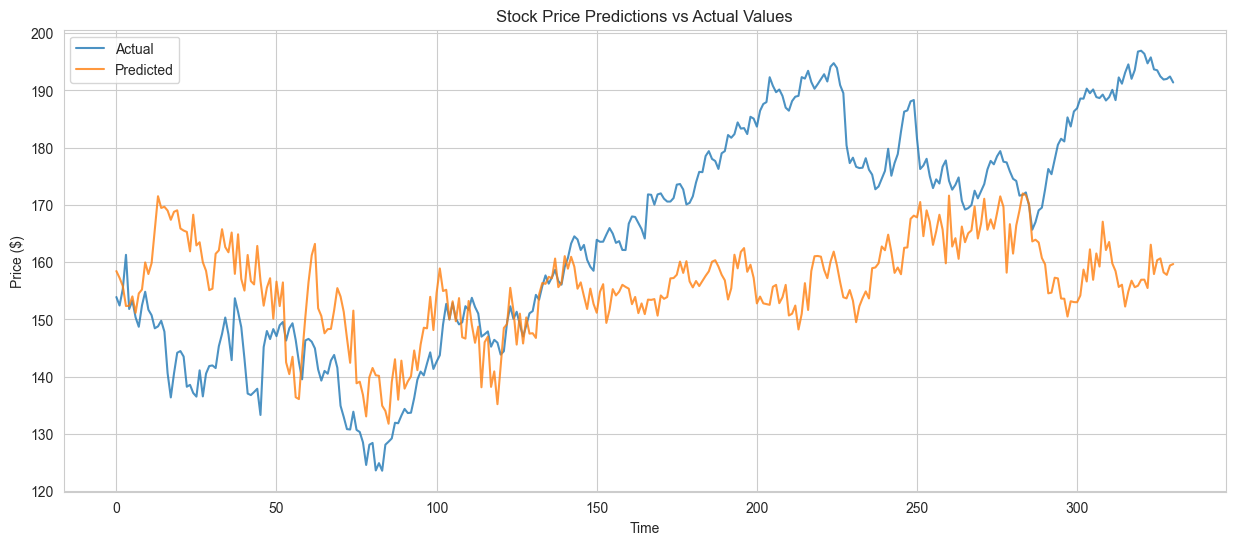

In [28]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.title('Model MAE Over Time')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print training summary
best_epoch = np.argmin(history.history['val_loss']) + 1
print("\nTraining Summary:")
print(f"Best epoch: {best_epoch}")
print(f"Best validation loss: {min(history.history['val_loss']):.4f}")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")

# Make predictions
print("\nMaking predictions...")
y_pred = model.predict(X_test)

# Convert predictions back to original scale
y_test_orig = scalers[1].inverse_transform(y_test)
y_pred_orig = scalers[1].inverse_transform(y_pred)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mae = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)

print("\nModel Performance Metrics:")
print(f"Root Mean Square Error (RMSE): ${rmse:.2f}")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"R-squared Score (R²): {r2:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(15, 6))
plt.plot(y_test_orig, label='Actual', alpha=0.8)
plt.plot(y_pred_orig, label='Predicted', alpha=0.8)
plt.title('Stock Price Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()